# Batch calibration & simulation

First create artificial returns from simple surrogate order-flow and the HDIM2 model. Then try to recover the kernels again and to predict the return using several different models.
You might need to `pip install matplotlib colorednoise` if you didn't install all of these optional packages yet.

In [1]:
import os

# set the backend
import matplotlib.pyplot as plt


# standard packages
import numpy as np
import pandas as pd

# included noise generator
from colorednoise import powerlaw_psd_gaussian

# propagator models
import priceprop as prop
import priceprop.batch as pb
import scorr

In [2]:
%load_ext autoreload
%autoreload 2

### Generate synthetic power-law correlated order-flow


In [3]:
# autocorrelation exponents
gamma_s = 0.5   # ... of the signs
gamma_c = 0.25  # ... of the price-change indicator
# time steps to simulate
steps = 10**5 # 10**4 already gives usable results

In [4]:
# signs
s = np.sign(powerlaw_psd_gaussian(1-gamma_s, steps)).astype(int)
# change indicator
c = (powerlaw_psd_gaussian(1-gamma_c, steps) > 0)

In [5]:
# simulate HDIM2 model as "ground truth"
# ---------------------------------------------

# maximum lag for propagator kernel
maxlag = 2**8
lags = np.arange(1,maxlag+1)

# time steps
t = np.arange(steps, dtype=int)

# some power law kernels
k_n = prop.k_pow(maxlag+1, prop.beta_from_gamma(gamma_s)) * 0.25
k_c = prop.k_pow(maxlag+1, prop.beta_from_gamma(gamma_s))
k_n[0] = 0
k_n[1] = .1

r = prop.hdim2(s, c, k_n, k_c)

Create a dataframe that resembles the way actual trading data may be analysed

In [6]:
# simulate split over different days
mean_day_length = 2**8
trades = pd.DataFrame({
    'r1':         r,  # one-step mid-return
    'sign':       s,  # sign of a single trade (buy: 1, sell: -1) 
    'change':     c,  # change indicator
    # simulate days of different lenghts
    'date':       np.cumsum(np.random.rand(len(c)) / mean_day_length).astype(int)
})
# split in two sample groups for out-of-sample analysis
trades['sample'] = trades['date'] % 2

In [7]:
trades.head()

,r1,sign,change,date,sample
0,-0.000000,-1,False,0,0
1,0.900000,1,True,0,0
2,-1.138838,-1,True,0,0
3,-0.908775,-1,True,0,0
4,-0.802973,-1,True,0,0


Now the trades are added to a dictionary which allows to collect also the price responses, correlation matrices, etc. for later analyses.

In [8]:
db = {'tt': trades} # tt stands for true trades, i.e. after merging transactions

In [9]:
db['tt']

,r1,sign,change,date,sample
0,-0.000000,-1,False,0,0
1,0.900000,1,True,0,0
2,-1.138838,-1,True,0,0
3,-0.908775,-1,True,0,0
4,-0.802973,-1,True,0,0
...,...,...,...,...,...
99995,0.756907,1,True,195,1
99996,-1.301914,-1,True,195,1
99997,-1.023924,-1,True,195,1
99998,1.107776,1,True,195,1


In [11]:
db['tt'].groupby("date").count().mean()

r1        510.204082
sign      510.204082
change    510.204082
sample    510.204082
dtype: float64

### Load real orderflow

In [6]:
stock = "AAPL"
current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')
filename = f"{stock}-2017-NEW.csv"
stock_file_path = os.path.join(data_dir, filename)
aapl_raw_df = pd.read_csv(stock_file_path)

In [7]:
aapl_raw_df.head()

,Unnamed: 0,event_timestamp,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,average_vol_at_best,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,0,2017-01-03 10:30:00.544161131,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,1045.040418,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.095690,100
1,1,2017-01-03 10:30:02.758712611,-1,BID,REMOVE,True,115.69,153,115.70,115.69,...,762.184840,-0.01,0.01,0.01,2017-01-03,0.004271,1398089,6170,0.200739,-153
2,2,2017-01-03 10:30:02.852790059,1,ASK,REMOVE,True,115.69,200,115.69,115.68,...,1045.040418,0.01,0.01,0.01,2017-01-03,0.004271,1398089,6170,0.191380,200
3,3,2017-01-03 10:30:04.539218241,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,1045.040418,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.095690,100
4,4,2017-01-03 10:30:07.865732286,1,ASK,UPDATE,True,115.70,10,115.70,115.69,...,1045.040418,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.009569,10


In [8]:
aapl_raw_df.columns

Index(['Unnamed: 0', 'event_timestamp', 'sign', 'side', 'lob_action',
       'order_executed', 'execution_price', 'size', 'ask', 'bid', 'midprice',
       'ask_volume', 'bid_volume', 'price_changing', 'ask_queue_size_mean',
       'bid_queue_size_mean', 'average_num_at_best', 'average_vol_at_best',
       'midprice_change', 'R1', 'spread', 'date', 'daily_R1', 'daily_vol',
       'daily_num', 'norm_size', 'signed_volume'],
      dtype='object')

In [9]:
aapl_data = aapl_raw_df[["event_timestamp", "R1", "sign", "price_changing"]]

In [10]:
aapl_data["event_timestamp"] = aapl_data["event_timestamp"].apply(lambda x: pd.Timestamp(x))
aapl_data["date"] = aapl_data["event_timestamp"].apply(lambda x: x.date())

/var/folders/ht/ftxq182137ngc38c1g4m9ff40000gn/T/ipykernel_74009/3569341304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_data["event_timestamp"] = aapl_data["event_timestamp"].apply(lambda x: pd.Timestamp(x))
/var/folders/ht/ftxq182137ngc38c1g4m9ff40000gn/T/ipykernel_74009/3569341304.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_data["date"] = aapl_data["event_timestamp"].apply(lambda x: x.date())


In [11]:
aapl_data.head()

,event_timestamp,R1,sign,price_changing,date
0,2017-01-03 10:30:00.544161131,0.00,1,True,2017-01-03
1,2017-01-03 10:30:02.758712611,0.01,-1,True,2017-01-03
2,2017-01-03 10:30:02.852790059,0.01,1,True,2017-01-03
3,2017-01-03 10:30:04.539218241,0.00,1,True,2017-01-03
4,2017-01-03 10:30:07.865732286,0.00,1,False,2017-01-03


In [12]:
aapl_data.groupby("date").count().mean()

event_timestamp    10493.936255
R1                 10493.936255
sign               10493.936255
price_changing     10493.936255
dtype: float64

In [13]:
trades = aapl_data[["R1", "sign", "price_changing", "date"]]
trades = trades.rename(columns={"R1": "r1", "price_changing": "change"})
trades['sample'] = trades["date"].apply(lambda x: x.day % 2)

trades.head()

,r1,sign,change,date,sample
0,0.00,1,True,2017-01-03,1
1,0.01,-1,True,2017-01-03,1
2,0.01,1,True,2017-01-03,1
3,0.00,1,True,2017-01-03,1
4,0.00,1,False,2017-01-03,1


In [14]:
trades["sample"].value_counts()

sample
1    1403128
0    1230850
Name: count, dtype: int64

In [18]:
shorter_sample_trades = trades.head(100000)

In [19]:
db = {'tt': shorter_sample_trades}

### Calibrate and simulate the models

In [20]:

pb.calc_models(db, nfft='pad > 300', group=True, calibrate=True, split_by='sample')
# nfft options from fast to precise: 'crop', 'pad', 'demix'
# the addition '> 300' specifies to drop groups with fewer than 300 events
# feedback can be obtained using Python's logging module.

/Users/ana_bugaenko/workspace/priceprop/priceprop/batch.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt['sc'] = tt['sign'] * tt['change']
/Users/ana_bugaenko/workspace/priceprop/priceprop/batch.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt['sn'] = tt['sign'] * (~tt['change'])
/Users/ana_bugaenko/workspace/priceprop/priceprop/batch.py:414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [21]:
# A calibration dict 'cal' was added to db. 
# It includes one key for each of the sample groups 
# (based on the column "samples" created above)
print("Calibration completed for the following sample groups:")
print(db['cal'].keys())

Calibration completed for the following sample groups:
dict_keys([0, 1])


In [22]:
# the simulated time-series should now be included in the trades dataframe
db['tt'].head(20)

,r1,sign,change,date,sample,sc,sn,r_cim,r_tim1,r_tim2,r_hdim2,r_hdim2_x2
0,0.00,1,True,2017-01-03,1,1,0,1.0,0.003371,0.006905,0.004133,0.006880
1,0.01,-1,True,2017-01-03,1,-1,0,-1.0,0.002000,-0.007323,0.002259,-0.006768
2,0.01,1,True,2017-01-03,1,1,0,1.0,-0.007786,-0.003363,-0.018039,-0.003889
3,0.00,1,True,2017-01-03,1,1,0,1.0,0.014879,0.020017,0.034974,0.020475
4,0.00,1,False,2017-01-03,1,0,1,0.0,-0.000059,-0.012394,-0.000000,-0.000000
5,0.00,1,False,2017-01-03,1,0,1,0.0,0.006077,0.013253,0.000000,0.000000
6,0.01,1,True,2017-01-03,1,1,0,1.0,0.000246,0.011160,0.015197,0.011668
7,0.00,1,False,2017-01-03,1,0,1,0.0,0.003056,-0.003674,-0.000000,-0.000000
8,0.00,1,False,2017-01-03,1,0,1,0.0,-0.003343,-0.001760,-0.000000,-0.000000
9,0.00,1,False,2017-01-03,1,0,1,0.0,0.006017,0.014894,0.000000,0.000000


### Plot fitted model kernels

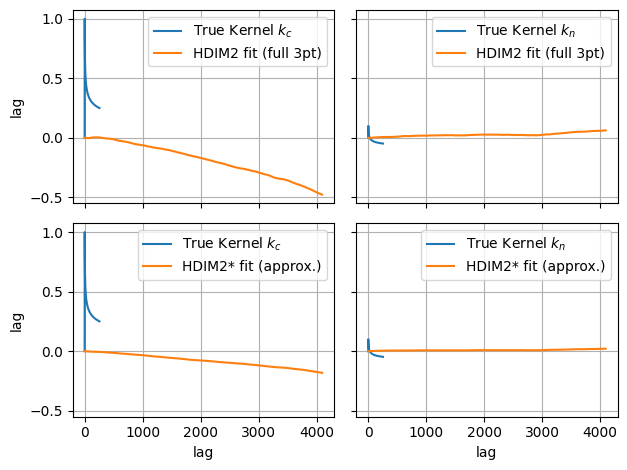

In [23]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

sample = 1 # choose of the keys listed above
fn = prop.integrate # show integrated kernels

ax[0,0].plot(fn(k_c), label='True Kernel $k_c$')
ax[0,0].plot(fn(db['cal'][sample]['kc']), label='HDIM2 fit (full 3pt)')
ax[0,0].legend()

ax[0,1].plot(fn(k_n), label='True Kernel $k_n$')
ax[0,1].plot(fn(db['cal'][sample]['kn']), label='HDIM2 fit (full 3pt)')
ax[0,1].legend()


ax[1,0].plot(fn(k_c), label='True Kernel $k_c$')
ax[1,0].plot(fn(db['cal'][sample]['kc_x2']), label='HDIM2* fit (approx.)')
ax[1,0].legend()

ax[1,1].plot(fn(k_n), label='True Kernel $k_n$')
ax[1,1].plot(fn(db['cal'][sample]['kn_x2']), label='HDIM2* fit (approx.)')
ax[1,1].legend()

# optimise
for a in ax[:,0]:
    a.set_ylabel('lag')
for a in ax[-1,:]:
    a.set_xlabel('lag')
for a in ax.flatten():
    a.grid(True)

plt.tight_layout()

### Plot the original "true" returns and those predicted from the fitted models

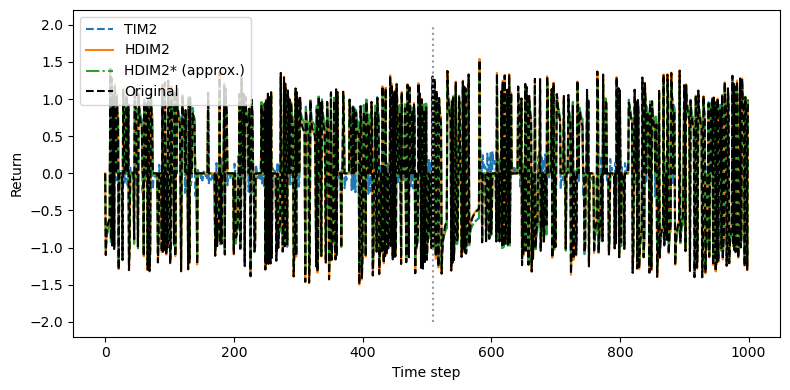

In [14]:
plt.figure(2, figsize=(8,4))
ax = plt.gca()

# choose a range between 0 and steps for the plot.
plot_start = 0
plot_end   = 1000
# plot the following predicted returns from these fitted models
# (un)comment lines to (de)select models
plot_models = [
    #'r_cim',
    #'r_tim1',
    'r_tim2',
    'r_hdim2',    # HDIM2 with full calibration
    'r_hdim2_x2' # HDIM2 with two-point approximation
]


# plot diverse models
rename_models = {
    i : i.upper().replace('R_','').replace('_X2','* (approx.)')
    for i in plot_models
}
styles = ['--','-','-.']
predicted_returns = (
    trades.iloc[plot_start:plot_end][plot_models]
    .rename(columns=rename_models)
)
predicted_returns.plot(style=styles,ax=ax)

# original returns
original_returns = trades.iloc[plot_start:plot_end][['r1']]
original_returns.columns = ['Original']
original_returns.plot(style='k--', ax=ax, )

# indicate date changes - there should be larger errors just at the beginning of a new day
plt.vlines(
    np.where(np.diff(trades['date'][plot_start:plot_end]))[0], 
    -2, 2, 
    linestyles=':', colors='#999999'
)

# format
ax.set_xlabel('Time step')
ax.set_ylabel('Return')
plt.tight_layout()

Zooming into the time series reveals that the HDIM2 is perfectly predicted using the correct calibration, but not as well using the approximate calibration or the TIM2.